In [4]:
!pip install gurobipy

     ---------------------------------------- 8.9/8.9 MB 5.7 MB/s eta 0:00:00


Impossibile trovare il percorso specificato.


In [11]:
from pulp import * 
currentdir = os.path.dirname(os.path.realpath("__file__"))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 
import utils

#python C:\Program Files\IBM\ILOG\CPLEX_Studio221\python\setup.py install
instance=utils.loadInstance("../instances/ins-40.txt")
print(listSolvers(onlyAvailable=True))
print(*[f" {key} = {val}\n" for key,val in instance.items()])

No parameters matching '_test' found
['GUROBI', 'GUROBI_CMD', 'PULP_CBC_CMD']
 n = 73
  w = 60
  dim = [[34, 6], [13, 3], [13, 5], [10, 12], [10, 12], [6, 7], [6, 15], [25, 7], [25, 15], [21, 12], [16, 7], [16, 5], [21, 3], [21, 5], [5, 7], [5, 5], [4, 1], [4, 10], [6, 13], [12, 13], [12, 9], [23, 6], [7, 3], [7, 5], [2, 1], [2, 10], [6, 6], [6, 5], [14, 7], [14, 6], [16, 3], [16, 5], [14, 6], [14, 5], [14, 13], [3, 2], [3, 7], [11, 2], [11, 7], [6, 7], [6, 6], [33, 14], [12, 4], [12, 3], [16, 18], [12, 3], [12, 18], [4, 4], [4, 3], [3, 1], [3, 2], [6, 9], [6, 9], [6, 1], [6, 2], [5, 7], [5, 18], [3, 9], [3, 9], [9, 18], [6, 5], [6, 2], [2, 12], [2, 9], [8, 3], [8, 9], [10, 9], [3, 5], [3, 2], [3, 18], [3, 7], [2, 3], [2, 9]]



In [12]:
#PARAMETERS
M=1000
WC=instance["w"]
n=instance["n"]
p=[i[0] for i in instance["dim"]]
q=[i[1] for i in instance["dim"]]
Hmax=sum(q)

# DECISION VARIABLES
W=[] # Width of block
H=[] # Height of block
Xl=[] # left boundary of block
Xr=[] # right boundary of block
Yt=[] # top boundary of block
Yb=[] # bottom boundary of block
R=[] # 0 if block i is to the left of block j
U=[] # 0 if block i is below block j
V=[] # rotations
tot_area=sum([w_i*h_i for w_i,h_i in zip(p,q)])
Hmin = tot_area/WC
import numpy as np
biggest_i=np.argmax([p[i]*q[i] for i in range(n)])
print(Hmin,Hmax)
HC=LpVariable(f"H_c",Hmin,Hmax,LpInteger)
for i in range(n):
    W.append(LpVariable(f"W_{i}",0,None,LpInteger))
    H.append(LpVariable(f"H_{i}",0,None,LpInteger))
    Xl.append(LpVariable(f"Xl_{i}",0,None,LpInteger))
    Xr.append(LpVariable(f"Xr_{i}",0,None,LpInteger))
    Yt.append(LpVariable(f"Yt_{i}",0,None,LpInteger))
    Yb.append(LpVariable(f"Yb_{i}",0,None,LpInteger))
    V.append(LpVariable(f"V_{i}",0,1,LpInteger))
    tempR=[]
    tempU=[]
    for j in range(n):
        if i!=j: 
            tempR.append(LpVariable(f"R_{i}_{j}",0,1,LpInteger))
            tempU.append(LpVariable(f"U_{i}_{j}",0,1,LpInteger))
        else:
            tempR.append(None)
            tempU.append(None)
    R.append(tempR)
    U.append(tempU)


90.0 529


In [182]:
def buildProblem():
    # PROBLEM FORMULATION    
    problem=LpProblem("VLSI_Problem", LpMinimize)

    problem += HC, "Chip_Height"
    # problem += HC*WC-tot_area >=0 ,"Empty_space"

    for i in range(n):
        problem += Xr[i]-Xl[i]==W[i], f"B_{i}_boundaries_LR"
        problem += Yt[i]-Yb[i]==H[i], f"B_{i}_boundaries_TB"
        problem += W[i]==p[i], f"B_{i}_width"
        problem += H[i]==q[i], f"B_{i}_heigth"
        problem += Yt[i]<=HC,  f"Max_{i}_ytpos"
        problem += Yt[i]>=q[i], f"Min_{i}_ybpos"
        #problem += W[i]== V[i]*p[i] + (1-V[i])*q[i], f"B_{i}_width"
        #problem += H[i]== (1-V[i])*p[i] + V[i]*q[i], f"B_{i}_height"
        for j in range(n):
            problem += Yt[i]-Yb[j]<=HC,  f"B_{i}_{j}_height_less_than_chip"
            problem += Xr[i]-Xl[j]<=WC,  f"B_{i}_{j}_width_less_than_chip"
            if i!=j:
                problem += R[i][j]+R[j][i]+U[i][j]+U[j][i]<=3, f"B_{i}_{j}_at_most_one_rel"
                problem += Xr[i]<=Xl[j]+M*R[i][j], f"B_{i}_{j}_non_overlap_horizontal"
                problem += Yt[i]<=Yb[j]+M*U[i][j], f"B_{i}_{j}_non_overlap_vertical"
    return problem

In [13]:
def buildProblem():
    # PROBLEM FORMULATION    
    problem=LpProblem("VLSI_Problem", LpMinimize)

    problem += HC, "Chip_Height"
    #  problem += HC*WC-tot_area >=0 ,"Empty_space"
    problem += 2*Xl[biggest_i]<=WC-p[biggest_i], "Largest_rectangle_Xpos"
    problem += 2*Yb[biggest_i]<=HC-q[biggest_i], "Largest_rectangle_Ypos"
    for i in range(n):
        problem += Yb[i]+q[i]<=HC,  f"Max_{i}_Ypos"
        #problem += W[i]== V[i]*p[i] + (1-V[i])*q[i], f"B_{i}_width"
        #problem += H[i]== (1-V[i])*p[i] + V[i]*q[i], f"B_{i}_height"
        for j in range(n):
            problem += Xl[i]+p[i]-Xl[j]<=WC,  f"B_{i}_{j}_width_less_than_chip"
            problem += Yb[i]+q[i]-Yb[j]<=HC,  f"B_{i}_{j}_height_less_than_chip"

            if i!=j:
                problem += Xl[i]+p[i]<=Xl[j]+M*R[i][j], f"B_{i}_{j}_non_overlap_horizontal"
                problem += Yb[i]+q[i]<=Yb[j]+M*U[i][j], f"B_{i}_{j}_non_overlap_vertical"
                if p[i]+p[j]>WC:
                    problem+= R[i][j]==1,f"B_{i}_{j}_too_large"
            if i<j:
                problem += R[i][j]+R[j][i]+U[i][j]+U[j][i]<=3, f"B_{i}_{j}_at_most_one_rel"                    
                if p[i]==p[j] and q[i]==p[j]:  
                        problem+= R[i][j]==1,f"B_{i}_{j}_same_size_r"    
                        problem+= U[i][j]==1,f"B_{i}_{j}_same_size_u"        
    return problem
#buildSolveShow()

In [14]:
def buildSolveShow():
    problem=buildProblem()
    #print(problem)
    problem.solve(GUROBI(timeLimit=300,msg=1))    
    #problem.solve(CPLEX_PY(timeLimit=300,msg=1))    
    solution=[[WC,int(HC.value())]]+[[p[i],q[i],round(Xl[i].value())+1,round(Yb[i].value())+1] for i in range(n)]
    print(solution, 'culo')
    utils.show(solution,figsize=(15,15),lw=0.1)
buildSolveShow()

Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 23911 rows, 10659 columns and 68588 nonzeros
Model fingerprint: 0xba1a6e21
Variable types: 0 continuous, 10659 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 5e+02]
  RHS range        [1e+00, 6e+01]
Presolve removed 330 rows and 73 columns
Presolve time: 0.15s
Presolved: 23581 rows, 10586 columns, 68078 nonzeros
Variable types: 0 continuous, 10586 integer (10439 binary)

Root relaxation: objective 9.000000e+01, 11649 iterations, 0.53 seconds (0.39 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   90.00000    0   38          -   90.00000      -     -    1s
     0     0   90.00000   

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

[[30, 65], [6, 18, 12, 1], [2, 12, 14, 42], [10, 7, 8, 54], [4, 23, 14, 19], [4, 1, 27, 1], [7, 7, 24, 59], [11, 4, 1, 1], [6, 5, 12, 61], [2, 7, 16, 42], [6, 11, 18, 37], [10, 19, 1, 5], [11, 5, 20, 18], [4, 2, 1, 24], [7, 5, 16, 49], [4, 2, 1, 34], [7, 12, 24, 47], [7, 13, 18, 24], [3, 6, 27, 2], [6, 10, 18, 56], [9, 16, 18, 1], [1, 4, 13, 20], [4, 10, 27, 8], [6, 24, 25, 23], [9, 9, 5, 24], [2, 1, 12, 19], [8, 5, 1, 61], [3, 5, 9, 61], [7, 25, 1, 36], [5, 21, 8, 33]]


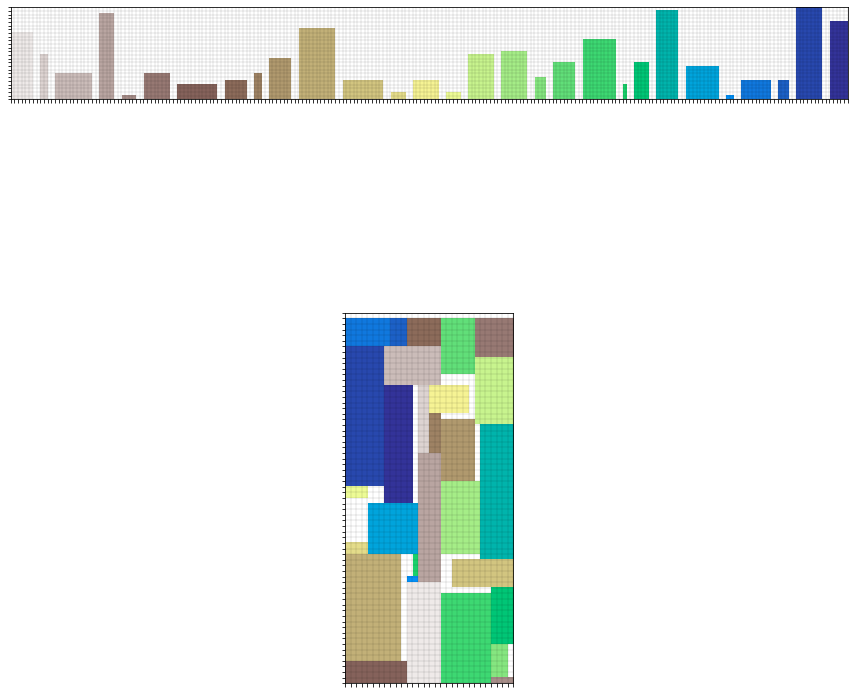

10


In [191]:
import matplotlib.pyplot as plt 
l=[[WC,int(HC.value())]]+[[p[i],q[i],round(Xl[i].value())+1,round(Yb[i].value())+1] for i in range(n)]
print(l)
#utils.show(solution,figsize=(15,15),lw=0.1)
ins = 38
displaySolution(f'Plate {ins}', l[0][0], l[0][1], len(l)-1,\
                         [i[:2] for i in l[1:][:]], [i[2:] for i in l[1:][:]])
print(biggest_i)
# 

In [150]:
print([y for y in q])
print([y.value() for y in Yb])
print()
print([y for y in p])
print([y.value() for y in Xl])


[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 22, 3, 19, 4]
[19.0, -0.0, 0.0, 13.0, -0.0, 14.0, 5.0, 12.0, 7.0, -0.0, 0.0, 4.0, -0.0, 19.0, -0.0, 18.0]

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 6]
[17.0, 7.0, 1.0, 17.0, 4.0, 1.0, 1.0, 14.0, 4.0, 14.0, 17.0, 7.0, 20.0, 10.0, 10.0, 4.0]
